In [1]:
from transformers import AutoTokenizer, LlamaForCausalLM, LlamaConfig

llama_causallm = LlamaForCausalLM.from_pretrained("NousResearch/Llama-2-7b-hf")
llamatok = AutoTokenizer.from_pretrained("NousResearch/Llama-2-7b-hf")
# llama_hf= AutoModel.from_pretrained("NousResearch/Llama-2-7b-hf")
config = LlamaConfig.from_pretrained("NousResearch/Llama-2-7b-hf")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
config

LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 4096,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "pad_token_id": 0,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "float16",
  "transformers_version": "4.42.4",
  "use_cache": true,
  "vocab_size": 32000
}

In [2]:
llama_sd = llama_hf.state_dict()

for k, v in llama_sd.items():
    print(k, v.shape)

embed_tokens.weight torch.Size([32000, 4096])
layers.0.self_attn.q_proj.weight torch.Size([4096, 4096])
layers.0.self_attn.k_proj.weight torch.Size([4096, 4096])
layers.0.self_attn.v_proj.weight torch.Size([4096, 4096])
layers.0.self_attn.o_proj.weight torch.Size([4096, 4096])
layers.0.mlp.gate_proj.weight torch.Size([11008, 4096])
layers.0.mlp.up_proj.weight torch.Size([11008, 4096])
layers.0.mlp.down_proj.weight torch.Size([4096, 11008])
layers.0.input_layernorm.weight torch.Size([4096])
layers.0.post_attention_layernorm.weight torch.Size([4096])
layers.1.self_attn.q_proj.weight torch.Size([4096, 4096])
layers.1.self_attn.k_proj.weight torch.Size([4096, 4096])
layers.1.self_attn.v_proj.weight torch.Size([4096, 4096])
layers.1.self_attn.o_proj.weight torch.Size([4096, 4096])
layers.1.mlp.gate_proj.weight torch.Size([11008, 4096])
layers.1.mlp.up_proj.weight torch.Size([11008, 4096])
layers.1.mlp.down_proj.weight torch.Size([4096, 11008])
layers.1.input_layernorm.weight torch.Size([409

In [2]:
llama_causal_sd = llama_causallm.state_dict()

for k, v in llama_causal_sd.items():
    print(k, v.shape)

model.embed_tokens.weight torch.Size([32000, 4096])
model.layers.0.self_attn.q_proj.weight torch.Size([4096, 4096])
model.layers.0.self_attn.k_proj.weight torch.Size([4096, 4096])
model.layers.0.self_attn.v_proj.weight torch.Size([4096, 4096])
model.layers.0.self_attn.o_proj.weight torch.Size([4096, 4096])
model.layers.0.mlp.gate_proj.weight torch.Size([11008, 4096])
model.layers.0.mlp.up_proj.weight torch.Size([11008, 4096])
model.layers.0.mlp.down_proj.weight torch.Size([4096, 11008])
model.layers.0.input_layernorm.weight torch.Size([4096])
model.layers.0.post_attention_layernorm.weight torch.Size([4096])
model.layers.1.self_attn.q_proj.weight torch.Size([4096, 4096])
model.layers.1.self_attn.k_proj.weight torch.Size([4096, 4096])
model.layers.1.self_attn.v_proj.weight torch.Size([4096, 4096])
model.layers.1.self_attn.o_proj.weight torch.Size([4096, 4096])
model.layers.1.mlp.gate_proj.weight torch.Size([11008, 4096])
model.layers.1.mlp.up_proj.weight torch.Size([11008, 4096])
model.l

In [10]:
import torch

tok_text = llamatok([
    "hi there",
    "hola senor how are you today"
], padding=True)
tok_text

{'input_ids': [[0, 0, 0, 0, 0, 0, 1, 7251, 727], [1, 298, 2963, 6940, 272, 920, 526, 366, 9826]], 'attention_mask': [[0, 0, 0, 0, 0, 0, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [11]:
torch.tensor(tok_text['input_ids']).shape

torch.Size([2, 9])

In [12]:
llama_causallm.generate(torch.tensor(tok_text['input_ids']), max_new_tokens=5)

tensor([[    0,     0,     0,     0,     0,     0,     1,  7251,   727,  7251,
           727,  7251,   727,  7251],
        [    1,   298,  2963,  6940,   272,   920,   526,   366,  9826,    13,
         29902, 29915, 29885,  2599]])

In [23]:
import torch
import torch.nn as nn
from dataclasses import dataclass

@dataclass
class LlamaConfig:
    vocab: int = 32_000
    n_embd: int = 8
    intermediate_size: int = 11008
    
    n_layers: int = 32
    n_heads: int = 4
    n_kv_heads: int = 2

    batch_size: int = 2
    ctx_len: int = 3

config = LlamaConfig

In [24]:
tril = torch.tril(torch.ones((config.ctx_len, config.ctx_len), dtype=torch.long))
tril

tensor([[1, 0, 0],
        [1, 1, 0],
        [1, 1, 1]])

In [25]:
tril.shape

torch.Size([3, 3])

In [59]:
q = nn.Linear(config.n_embd, config.n_embd)
k = nn.Linear(config.n_embd, config.n_embd)

In [53]:
x = torch.rand((config.batch_size, config.ctx_len, config.n_embd))
x.shape

torch.Size([2, 3, 8])

In [54]:
B, T, C = x.shape
query = q(x)
print(query.shape)

query = query.view(B, T, config.n_heads, C // config.n_heads).transpose(1, 2)
print(query.shape)

torch.Size([2, 3, 8])
torch.Size([2, 4, 3, 2])


In [58]:
# k = k.unsqueeze(1).expand(-1, self.num_heads // self.kv_heads, -1, -1, -1)  # (B, n_heads // kv_heads, kv_heads, T, kv_head_dim)
query

tensor([[[[[-0.6331,  0.6262],
           [-0.1049,  0.4341],
           [-0.3236,  0.3640]],

          [[ 0.4240, -0.0697],
           [ 0.2945, -0.1620],
           [-0.0332, -0.1282]]],


         [[[ 0.2726,  0.0698],
           [ 0.5509, -0.0648],
           [ 0.3931, -0.1777]],

          [[ 0.0319,  0.6081],
           [-0.0959,  0.5124],
           [-0.1237,  0.7668]]]],



        [[[[-0.1491,  0.4938],
           [-0.1628,  0.2734],
           [-0.2886,  0.4039]],

          [[-0.1964,  0.3093],
           [ 0.0710,  0.0148],
           [-0.2560,  0.3555]]],


         [[[ 0.2366,  0.0188],
           [ 0.5626, -0.2082],
           [ 0.2074,  0.0888]],

          [[ 0.3507,  0.5721],
           [ 0.0201,  0.4847],
           [ 0.4706,  0.6150]]]]], grad_fn=<ViewBackward0>)

In [56]:
query = query.view(B, config.n_heads // config.n_kv_heads, config.n_kv_heads, T, C // config.n_heads)
print(query.shape)

torch.Size([2, 2, 2, 3, 2])


In [57]:
query[0]

tensor([[[[-0.6331,  0.6262],
          [-0.1049,  0.4341],
          [-0.3236,  0.3640]],

         [[ 0.4240, -0.0697],
          [ 0.2945, -0.1620],
          [-0.0332, -0.1282]]],


        [[[ 0.2726,  0.0698],
          [ 0.5509, -0.0648],
          [ 0.3931, -0.1777]],

         [[ 0.0319,  0.6081],
          [-0.0959,  0.5124],
          [-0.1237,  0.7668]]]], grad_fn=<SelectBackward0>)

In [69]:
key = k(x)
print(key.shape)
key = key.view(B, T, config.n_kv_heads, C // config.n_kv_heads).transpose(1, 2)
print(key.shape)

torch.Size([2, 3, 8])
torch.Size([2, 2, 3, 4])


In [70]:
print(key)
key = key.unsqueeze(1)
print(key.shape)

tensor([[[[-0.1733, -0.1279,  0.1068,  0.4391],
          [-0.2818,  0.2603, -0.1590,  0.4544],
          [-0.2071,  0.0117, -0.1461,  0.4070]],

         [[ 0.1569, -0.0777,  0.1505,  0.3660],
          [ 0.4668, -0.2868,  0.3001,  0.1590],
          [ 0.3735, -0.0797,  0.3620,  0.1053]]],


        [[[ 0.0860, -0.1571, -0.3969,  0.4523],
          [-0.1444,  0.0679, -0.1109,  0.4496],
          [ 0.0957, -0.1687, -0.3900,  0.4769]],

         [[ 0.3522, -0.2438,  0.3827,  0.1023],
          [ 0.5150, -0.3657,  0.4548,  0.3809],
          [ 0.2946, -0.2785,  0.4773,  0.1715]]]],
       grad_fn=<TransposeBackward0>)
torch.Size([2, 1, 2, 3, 4])


In [67]:
key = key.expand(-1, config.n_heads // config.n_kv_heads, -1, -1 , -1)
print(key.shape)

torch.Size([2, 2, 2, 3, 4])


In [68]:
key

tensor([[[[[-0.1733, -0.1279,  0.1068,  0.4391],
           [-0.2818,  0.2603, -0.1590,  0.4544],
           [-0.2071,  0.0117, -0.1461,  0.4070]],

          [[ 0.1569, -0.0777,  0.1505,  0.3660],
           [ 0.4668, -0.2868,  0.3001,  0.1590],
           [ 0.3735, -0.0797,  0.3620,  0.1053]]],


         [[[-0.1733, -0.1279,  0.1068,  0.4391],
           [-0.2818,  0.2603, -0.1590,  0.4544],
           [-0.2071,  0.0117, -0.1461,  0.4070]],

          [[ 0.1569, -0.0777,  0.1505,  0.3660],
           [ 0.4668, -0.2868,  0.3001,  0.1590],
           [ 0.3735, -0.0797,  0.3620,  0.1053]]]],



        [[[[ 0.0860, -0.1571, -0.3969,  0.4523],
           [-0.1444,  0.0679, -0.1109,  0.4496],
           [ 0.0957, -0.1687, -0.3900,  0.4769]],

          [[ 0.3522, -0.2438,  0.3827,  0.1023],
           [ 0.5150, -0.3657,  0.4548,  0.3809],
           [ 0.2946, -0.2785,  0.4773,  0.1715]]],


         [[[ 0.0860, -0.1571, -0.3969,  0.4523],
           [-0.1444,  0.0679, -0.1109,  0.4496],


In [2]:
import torch

x = torch.arange(1,7).reshape(2, 3)
y = torch.arange(2, 7, 2)
x, y

(tensor([[1, 2, 3],
         [4, 5, 6]]),
 tensor([2, 4, 6]))

In [3]:
torch.einsum('bt,t->b', [x, y])

tensor([28, 64])

In [4]:
from einops import rearrange, reduce, repeat
g = torch.arange(6)
g

tensor([0, 1, 2, 3, 4, 5])

In [22]:
x = torch.arange(6,12).reshape(2, 3)
y = torch.arange(6).reshape(2, 3)
print(x)
print(y)
torch.einsum('ij, kj ->ik', [x, y])

tensor([[ 6,  7,  8],
        [ 9, 10, 11]])
tensor([[0, 1, 2],
        [3, 4, 5]])


tensor([[ 23,  86],
        [ 32, 122]])

In [23]:
torch.einsum('ij, kj ->ki', [x, y])

tensor([[ 23,  32],
        [ 86, 122]])

In [24]:
torch.einsum('ij, kj ->', [x, y])

tensor(263)

In [25]:
torch.einsum('ij, ij ->', [x, y])

tensor(145)

In [26]:
torch.einsum('ij, ij ->ij', [x, y])

tensor([[ 0,  7, 16],
        [27, 40, 55]])

In [7]:
torch.einsum('i, j -> ij', [x, y])

tensor([[0, 0, 0, 0],
        [0, 1, 2, 3],
        [0, 2, 4, 6]])

In [19]:
torch.einsum('i, j -> ji', [x, y])

RuntimeError: einsum(): the number of subscripts in the equation (1) does not match the number of dimensions (2) for operand 0 and no ellipsis was given

### RoPE embeddings (LLama2 version)

In [2]:
import torch
device = "cuda:0"
dim = 6
seq_len = 4

# Calculate the rotation frequencies for positional embeddings
theta_numerator = torch.arange(0, dim, 2, dtype=torch.float32)

# 10_000 ** (-2(i - 1)/dim) ?== 1 / 10_000 ** (theta_numerator / dim) --> How and why? where does the 2 from -2 go?
theta = 1.0 / torch.pow(10000, theta_numerator / dim).to(device) 


In [3]:
theta_numerator

tensor([0., 2., 4.])

In [4]:
theta

tensor([1.0000, 0.0464, 0.0022], device='cuda:0')

In [5]:
# Generate frequency values for positional embeddings
m = torch.arange(seq_len, dtype=torch.float32).to(device)
freqs = torch.outer(m, theta).float()

In [6]:
freqs_ein = torch.einsum('i,j -> ij', [m, theta])
freqs_ein.allclose(freqs)

True

In [7]:
m, freqs

(tensor([0., 1., 2., 3.], device='cuda:0'),
 tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.0000e+00, 4.6416e-02, 2.1544e-03],
         [2.0000e+00, 9.2832e-02, 4.3089e-03],
         [3.0000e+00, 1.3925e-01, 6.4633e-03]], device='cuda:0'))

In [8]:
torch.ones_like(freqs)

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')

In [9]:
# Convert frequency values to complex numbers (polar form)
freqs_complex = torch.polar(torch.ones_like(freqs), freqs)
freqs_complex

tensor([[ 1.0000+0.0000j,  1.0000+0.0000j,  1.0000+0.0000j],
        [ 0.5403+0.8415j,  0.9989+0.0464j,  1.0000+0.0022j],
        [-0.4161+0.9093j,  0.9957+0.0927j,  1.0000+0.0043j],
        [-0.9900+0.1411j,  0.9903+0.1388j,  1.0000+0.0065j]], device='cuda:0')

In [14]:
x = torch.randn((1, seq_len, dim))
batch_size, seq_len, dim = x.shape
print(x.shape)
print(x)

torch.Size([1, 4, 6])
tensor([[[ 1.3423,  1.4161, -2.0025, -1.7465,  0.2864,  0.0080],
         [ 0.1996, -0.7018, -0.0306,  1.2341,  0.9267,  0.1319],
         [ 0.8582,  1.3198,  0.3466, -0.7029, -1.5371, -0.6479],
         [-0.4696,  0.5983, -0.2232, -0.1763, -0.9025, -0.4777]]])


In [57]:
x.float().reshape(*x.shape[:-1], -1, 2).shape

torch.Size([1, 4, 3, 2])

In [59]:
# Reshape the input into a complex tensor for rotational operations
# (B, SeqLen, H, Head_Dim) -> (B, SeqLen, H, Head_Dim // 2)
x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2)).to(device)
x_complex, x_complex.shape

(tensor([[[ 1.3423+1.4161j, -2.0025-1.7465j,  0.2864+0.0080j],
          [ 0.1996-0.7018j, -0.0306+1.2341j,  0.9267+0.1319j],
          [ 0.8582+1.3198j,  0.3466-0.7029j, -1.5371-0.6479j],
          [-0.4696+0.5983j, -0.2232-0.1763j, -0.9025-0.4777j]]],
        device='cuda:0'),
 torch.Size([1, 4, 3]))

In [70]:
start_pos = 0
# Extract rotational frequencies for the given sequence length and start position
# (SeqLen, Head_Dim // 2) -> (1, SeqLen, 1, Head_Dim // 2)
freq_complex = freqs_complex[start_pos:start_pos + seq_len]
freq_complex_mod = freq_complex.unsqueeze(0).to(device)
freq_complex.shape, freq_complex

(torch.Size([4, 3]),
 tensor([[ 1.0000+0.0000j,  1.0000+0.0000j,  1.0000+0.0000j],
         [ 0.5403+0.8415j,  0.9989+0.0464j,  1.0000+0.0022j],
         [-0.4161+0.9093j,  0.9957+0.0927j,  1.0000+0.0043j],
         [-0.9900+0.1411j,  0.9903+0.1388j,  1.0000+0.0065j]], device='cuda:0'))

In [71]:
freq_complex.unsqueeze(0)

tensor([[[ 1.0000+0.0000j,  1.0000+0.0000j,  1.0000+0.0000j],
         [ 0.5403+0.8415j,  0.9989+0.0464j,  1.0000+0.0022j],
         [-0.4161+0.9093j,  0.9957+0.0927j,  1.0000+0.0043j],
         [-0.9900+0.1411j,  0.9903+0.1388j,  1.0000+0.0065j]]],
       device='cuda:0')

In [72]:
freq_complex.unsqueeze(0).unsqueeze(2).shape, x_complex.shape

(torch.Size([1, 4, 1, 3]), torch.Size([1, 4, 3]))

In [80]:
# Apply rotational transformation to the input using frequency values
# (B, SeqLen, H, Head_Dim // 2) * (1, SeqLen, 1, Head_Dim // 2) -> (B, SeqLen, H, Head_Dim // 2)
x_rotated = x_complex * freq_complex_mod

In [81]:
freq_complex_mod

tensor([[[ 1.0000+0.0000j,  1.0000+0.0000j,  1.0000+0.0000j],
         [ 0.5403+0.8415j,  0.9989+0.0464j,  1.0000+0.0022j],
         [-0.4161+0.9093j,  0.9957+0.0927j,  1.0000+0.0043j],
         [-0.9900+0.1411j,  0.9903+0.1388j,  1.0000+0.0065j]]],
       device='cuda:0')

In [83]:
x_rotated

tensor([[[ 1.3423+1.4161j, -2.0025-1.7465j,  0.2864+0.0080j],
         [ 0.6984-0.2112j, -0.0879+1.2314j,  0.9264+0.1339j],
         [-1.5572+0.2312j,  0.4103-0.6678j, -1.5343-0.6546j],
         [ 0.3804-0.6586j, -0.1965-0.2056j, -0.8994-0.4835j]]],
       device='cuda:0')

In [84]:
x_complex

tensor([[[ 1.3423+1.4161j, -2.0025-1.7465j,  0.2864+0.0080j],
         [ 0.1996-0.7018j, -0.0306+1.2341j,  0.9267+0.1319j],
         [ 0.8582+1.3198j,  0.3466-0.7029j, -1.5371-0.6479j],
         [-0.4696+0.5983j, -0.2232-0.1763j, -0.9025-0.4777j]]],
       device='cuda:0')

In [85]:
# Convert the rotated complex tensor back to real-valued tensor
# (B, SeqLen, H, Head_Dim // 2) -> (B, SeqLen, H , Head_Dim // 2, 2)
x_out = torch.view_as_real(x_rotated)
x_out

tensor([[[[ 1.3423,  1.4161],
          [-2.0025, -1.7465],
          [ 0.2864,  0.0080]],

         [[ 0.6984, -0.2112],
          [-0.0879,  1.2314],
          [ 0.9264,  0.1339]],

         [[-1.5572,  0.2312],
          [ 0.4103, -0.6678],
          [-1.5343, -0.6546]],

         [[ 0.3804, -0.6586],
          [-0.1965, -0.2056],
          [-0.8994, -0.4835]]]], device='cuda:0')

In [86]:
# Reshape to match the original input shape
# (B, SeqLen, H , Head_Dim // 2, 2) -> (B, SeqLen, H, Head_Dim)
x_out = x_out.reshape(*x.shape)
x_out.type_as(x)

tensor([[[ 1.3423,  1.4161, -2.0025, -1.7465,  0.2864,  0.0080],
         [ 0.6984, -0.2112, -0.0879,  1.2314,  0.9264,  0.1339],
         [-1.5572,  0.2312,  0.4103, -0.6678, -1.5343, -0.6546],
         [ 0.3804, -0.6586, -0.1965, -0.2056, -0.8994, -0.4835]]])

In [87]:
x

tensor([[[ 1.3423,  1.4161, -2.0025, -1.7465,  0.2864,  0.0080],
         [ 0.1996, -0.7018, -0.0306,  1.2341,  0.9267,  0.1319],
         [ 0.8582,  1.3198,  0.3466, -0.7029, -1.5371, -0.6479],
         [-0.4696,  0.5983, -0.2232, -0.1763, -0.9025, -0.4777]]])

In [88]:
'''
Rope Embeddings step by step:
 Setup:
 - make some `theta_numerator` tensor of length (hidden_dim / 2) because each theta is applied to a pair of dimensions at a time
 - calculate thetas from the tensor above using formula: 1 / (10_000 ** (theta_numerator / hidden_dim))
 - make a `m` tensor of size 0, seq_len to calculate the theta freqs per token along the entire seq_len(prompt)
 - calculate `theta_freqs` by doing an outer product between `m` and `thetas` giving us a matrix of shape (m, thetas)
 - `theta_freqs` hold the angle of rotations in radians and we will use a magnitude of 1 on it to convert it to polar coordinates complex number in the form (x+iy)
 - the above computation gives us freqs_complex which is what we will use with the actual hidden embeddings of each token in a given batch of contexts.
 
 Computation:
 - Given a user supplied matrix x with shape (batch_size, ctx_len, hidden_dim) lets compute the output with RoPE applied with `freqs_complex`.
 - reshape the x matrix's hidden_dim to half with each consequitive pair as a tensor. so (B, T, C) -> (B, T, C//2, 2)
 - get `x_complex` by converting the reshaped x to complex from (x+iy) using the consequitive pairs [d1, d2] -> [d1+(i*d2)]. so (B, T, C//2, 2) -> (B, T, C//2)
 - take a subset of freqs_complex from [start_pos: start_pos+seq_len] then add a batch dimension into it to match the x matrix
 - now we can calculate `x_rotated` by doing `x_complex * freqs_complex`
 - convert back x_rotated into real numbers and reshape it into the original x.shape to return
'''

"\nRope Embeddings step by step:\n Setup:\n - make some `theta_numerator` tensor of length (hidden_dim / 2) because each theta is applied to a pair of dimensions at a time\n - calculate thetas from the tensor above using formula: 1 / (10_000 ** (theta_numerator / hidden_dim))\n - make a `m` tensor of size 0, seq_len to calculate the theta freqs per token along the entire seq_len(prompt)\n - calculate `theta_freqs` by doing an outer product between `m` and `thetas` giving us a matrix of shape (m, thetas)\n - `theta_freqs` hold the angle of rotations in radians and we will use a magnitude of 1 on it to convert it to polar coordinates complex number in the form (x+iy)\n - the above computation gives us freqs_complex which is what we will use with the actual hidden embeddings of each token in a given batch of contexts.\n \n Computation:\n - Given a user supplied matrix x with shape (batch_size, ctx_len, hidden_dim) lets compute the output with RoPE applied with `freqs_complex`.\n - reshape

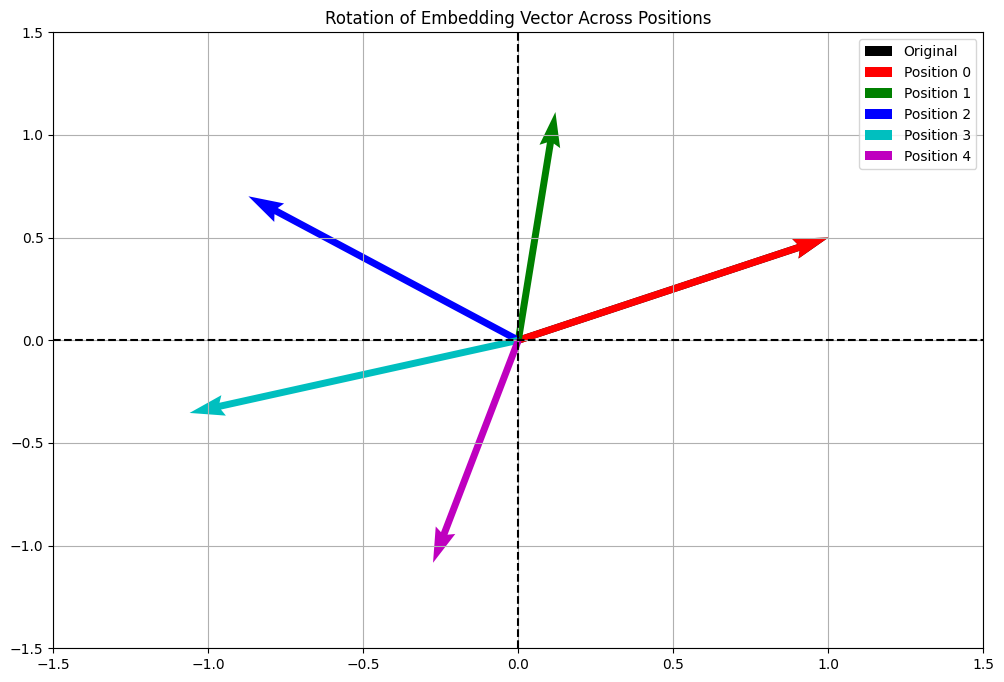

In [60]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_thetas(dim, max_seq_len):
    theta = 1.0 / (10000000 ** (np.arange(0, dim, 2) / dim))
    return np.outer(np.arange(max_seq_len), theta)

def rotate_embedding(embedding, freq):
    return np.array([
        embedding[0] * np.cos(freq) - embedding[1] * np.sin(freq),
        embedding[1] * np.cos(freq) + embedding[0] * np.sin(freq)
    ])

# Parameters
dim = 2
max_seq_len = 5
embedding = np.array([1.0, 0.5])  # Sample 2D embedding

# Calculate thetas and frequencies
thetas = calculate_thetas(dim, max_seq_len)
freqs = thetas[:, 0]  # We only need one frequency for 2D

# Create plot
plt.figure(figsize=(12, 8))
colors = ['r', 'g', 'b', 'c', 'm']

# Plot original embedding
plt.quiver(0, 0, embedding[0], embedding[1], angles='xy', scale_units='xy', scale=1, color='k', label='Original')

# Plot rotated embeddings for each position
for i in range(max_seq_len):
    rotated = rotate_embedding(embedding, freqs[i])
    plt.quiver(0, 0, rotated[0], rotated[1], angles='xy', scale_units='xy', scale=1, color=colors[i], label=f'Position {i}')

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.axhline(y=0, color='k', linestyle='--')
plt.axvline(x=0, color='k', linestyle='--')
plt.title("Rotation of Embedding Vector Across Positions")
plt.legend()
plt.grid(True)
plt.show()

# GQA and KV Cahce exploration

In [42]:
import torch
import torch.nn as nn

B, T, C = 1, 3, 16
n_h = 8
n_kv = 4
head_dim = C // n_h


x = torch.randn(B, T, C)
x

tensor([[[-1.5204,  1.5813, -0.8119, -0.1980, -1.0543, -0.3699,  0.4805,
           1.6361, -0.3640, -0.9520, -0.7434, -0.1114, -0.7222, -0.5762,
          -1.4665,  1.8727],
         [-0.0794,  0.0806, -0.3277, -1.4001,  1.9050,  1.4422, -0.6071,
          -0.7129,  0.7474, -0.3518,  0.6445, -0.6842, -0.9471,  0.0410,
           0.4453, -1.1886],
         [-1.0257,  1.2542,  1.1221,  1.2400, -1.2828, -2.0284, -0.9213,
           0.3568,  0.1994, -0.2210,  0.9318,  2.3968, -0.4180,  0.3691,
          -1.6963,  0.7842]]])

In [43]:
head_dim

2

In [44]:
q_proj = nn.Linear(C, n_h * head_dim)
k_proj = nn.Linear(C, n_kv * head_dim)
v_proj = nn.Linear(C, n_kv * head_dim)

In [45]:

x_query = q_proj(x)
x_key = k_proj(x)
x_val = v_proj(x)

x_query.shape, x_key.shape, x_val.shape

(torch.Size([1, 3, 16]), torch.Size([1, 3, 8]), torch.Size([1, 3, 8]))

In [46]:
query = x_query.view(B, T, n_h, C // n_h).transpose(1, 2)
key = x_key.view(B, T, n_kv, C // n_h).transpose(1, 2)
val = x_val.view(B, T, n_kv, C // n_h).transpose(1, 2)

In [47]:
query.shape, key.shape, val.shape

(torch.Size([1, 8, 3, 2]), torch.Size([1, 4, 3, 2]), torch.Size([1, 4, 3, 2]))

In [48]:
query_exp = query.view(B, n_h // n_kv, n_kv, T, head_dim)
key_exp = key.unsqueeze(1).expand(-1, n_h // n_kv, -1, -1, -1)
val_exp = val.unsqueeze(1).expand(-1, n_h // n_kv, -1, -1, -1)
query_exp.shape, key_exp.shape, val_exp.shape

(torch.Size([1, 2, 4, 3, 2]),
 torch.Size([1, 2, 4, 3, 2]),
 torch.Size([1, 2, 4, 3, 2]))

In [49]:
import math

wei = torch.einsum('bahtd, bahTd -> bahtT', [query_exp, key_exp]) / math.sqrt(n_h)

In [50]:
wei.shape

torch.Size([1, 2, 4, 3, 3])

In [51]:
out = torch.einsum('bahtT, bahTd -> bahtd', [wei, val_exp])

In [53]:
out.shape

torch.Size([1, 2, 4, 3, 2])

In [56]:
out.transpose(2, 3).contiguous().view(B, n_h // n_kv, T, n_kv * head_dim)

tensor([[[[-0.0054, -0.0083,  0.0849,  0.2444, -0.0853,  0.1332,  0.0249,
           -0.0093],
          [ 0.0153, -0.0295,  0.0314,  0.0922,  0.1231, -0.1507,  0.1991,
           -0.0557],
          [-0.0393,  0.0497, -0.0048, -0.0675, -0.3809,  0.4593,  0.0375,
           -0.0170]],

         [[-0.0242,  0.0314, -0.0780, -0.2936, -0.4152,  0.4652,  0.4303,
           -0.1305],
          [ 0.0419, -0.0538,  0.0267,  0.2599,  0.1954, -0.1702, -0.6121,
            0.1822],
          [-0.0528,  0.0742, -0.0721, -0.4597, -0.0354,  0.0726,  0.9044,
           -0.2717]]]], grad_fn=<ViewBackward0>)

In [13]:
import torch
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("NousResearch/Llama-2-7b-hf")

prompts = [
    "I am a student",
    "When is the bus getting here",
    "Would it be great if it was sunny?",
    "I am therefore I am",
    "I am not therefore I am not"
]

prompt_toks = [tokenizer(i, add_special_tokens=False)['input_ids'] for i in prompts]

In [14]:
prompt_toks

[[306, 626, 263, 8368],
 [1932, 338, 278, 3593, 2805, 1244],
 [10878, 372, 367, 2107, 565, 372, 471, 6575, 1460, 29973],
 [306, 626, 5480, 306, 626],
 [306, 626, 451, 5480, 306, 626, 451]]

In [15]:
max(prompt_toks, key=lambda x: len(x))

[10878, 372, 367, 2107, 565, 372, 471, 6575, 1460, 29973]